# Stuart Landau Example 

This notebook contains the 2D-Stuart-Landau example from the MCBB paper that varies $p_r$. For all details please see the paper. The other Stuart Landau configurations are in seperate files

For loading the saved jld files use the branch `old-state-sl-paper` of MCBB. 

In [1]:
cluster = false
calc_distance = false 
using Distributed
if cluster
    using ClusterManagers
    N_tasks = parse(Int, ARGS[1])
    task_type = parse(Int, ARGS[2])
    SAVE_NAME = ARGS[3]

    if task_type == 1
        N_worker = N_tasks
        addprocs(SlurmManager(N_worker))
        calc_mc = true 
    elseif task_type == 2
        calc_mc = false
        calc_distance = true
    else
        error("Unkown task_type, 1: Solve MCBB Problem, 2: Compute Distances")
    end
else
    SAVE_NAME = "stuart-landau-standard-multi-pr"
    using Plots

    import PyPlot, GraphPlot
end

@everywhere using MCBB
using JLD2, Clustering, LinearAlgebra, SparseArrays
@everywhere using Parameters, Distributions, DifferentialEquations, StatsBase, LightGraphs





@everywhere struct stuart_landau_sathiyadevi_pars <: DEParameters
    lambda::Real
    omega::Real
    eps::Real
    N::Int
    P_1::Int
    P_2::Int
    A_1::AbstractArray
    A_2::AbstractArray
end

@everywhere function stuart_landau_sathiyadevi_pars(lambda::Real, omega::Real, eps::Real, N::Int, P_1::Int, P_2::Int, p_r::Number=0.)
    A_1 = Bool.(adjacency_matrix(watts_strogatz(N, 2*P_1, p_r)))
    A_2 = Bool.(adjacency_matrix(watts_strogatz(N, 2*P_2, p_r)))
    stuart_landau_sathiyadevi_pars(lambda, omega, eps, N, P_1, P_2, A_1, A_2)
end

@everywhere function stuart_landau_sathiyadevi_pars(lambda::Real, omega::Real, eps::Real, N::Int, r_1::Real, r_2::Real)
    P_1 = Int(round(r_1*N))
    P_2 = Int(round(r_2*N))
    stuart_landau_sathiyadevi_pars(lambda, omega, eps, N, P_1, P_2)
end


@everywhere function stuart_landau_sathiyadevi!(dz,z,p::stuart_landau_sathiyadevi_pars,t)
    epsP1 = p.eps/(2*p.P_1)
    epsP2 = p.eps/(2*p.P_2)

    for i=1:p.N
        attr_coup = 0.
        for j=1:N
            if p.A_1[i,j]
               attr_coup += complex(real(z[j]) - real(z[i]),0)
            end
        end
        attr_coup *= epsP1

        repul_coup = 0.
        for j=1:p.N
            if p.A_2[i,j]
                repul_coup += complex(0., imag(z[j]) - imag(z[i]))
            end
        end
        repul_coup *= epsP2

        dz[i] = (complex(p.lambda,p.omega) - abs(z[i])^2)*z[i] + attr_coup - repul_coup
    end
end



@everywhere N = 100
@everywhere r_1 = 0.01
@everywhere P_1 = 1
@everywhere r_2 = 0.22
@everywhere P_2 = 22
@everywhere omega = 2.0
@everywhere lambda = 1.0
@everywhere epsval = 2.02
@everywhere pars = stuart_landau_sathiyadevi_pars(lambda, omega, epsval, N, r_1, r_2)

@everywhere epsilons = () -> rand(Uniform(1.7,2.5))
@everywhere p_r_gen = () -> rand(Uniform(0.,0.15))
@everywhere r_2_gen = () -> rand(Uniform(0.01,0.24))
@everywhere ic_dist = () -> complex(rand(Uniform(-1,1)),rand(Uniform(-1,1)))

@everywhere N_ics = 18000
@everywhere tail_frac = 0.7

#-@everywhere par_vars = (:eps, epsilons)

@everywhere new_sls_pars(old_par::stuart_landau_sathiyadevi_pars; eps=2.02, p_r=0.0) = stuart_landau_sathiyadevi_pars(old_par.lambda, old_par.omega, eps, old_par.N, P_1, P_2, p_r)
@everywhere par_vars = MultiDimParameterVar([OneDimParameterVar(:eps, epsilons),OneDimParameterVar(:p_r,p_r_gen)], new_sls_pars)

@everywhere odeprob = ODEProblem(stuart_landau_sathiyadevi!, rand(Complex{Float64},N), (0.,200.), pars)


@everywhere mean_real(arr::Array{Complex{Float64},1}, past_measures::AbstractArray) = mean(real.(arr))
@everywhere std_real(arr::Array{Complex{Float64},1}, past_measures::AbstractArray) = std(real.(arr); mean=past_measures[1])
@everywhere kl_real(arr::AbstractArray, past_measures::AbstractArray) = empirical_1D_KL_divergence_hist(real.(arr), past_measures)

@everywhere mean_imag(arr::Array{Complex{Float64},1}, past_measures::AbstractArray) = mean(imag.(arr))
@everywhere std_imag(arr::Array{Complex{Float64},1}, past_measures::AbstractArray) = std(imag.(arr); mean=past_measures[4])
@everywhere kl_imag(arr::AbstractArray, past_measures::AbstractArray) = empirical_1D_KL_divergence_hist(imag.(arr), [past_measures[4], past_measures[5]])

@everywhere std_max(arr::AbstractArray) = maximum(std(real.(arr)))

@everywhere function eval_ode_run_stuart(sol,i)
    (N_dim, __) = size(sol)
    state_filter = collect(1:N)
    eval_funcs = [mean_real, std_real, kl_real, mean_imag, std_imag, kl_imag]
    global_eval_funcs = [std_max]
    matrix_eval_funcs = [correlation_ecdf]
    eval_ode_run(sol, i, state_filter, eval_funcs, matrix_eval_funcs, global_eval_funcs, flag_past_measures=true)
end


distance_func = (x,y)->sum(abs.(x.-y))

weights = [0.25, 1., 0., 0.25, 1., 0., 0., 0.5, 1.,0.5]
K_BIN_FAC = .25

if cluster
    prob = DEMCBBProblem(odeprob, ic_dist, N_ics, pars, par_vars, eval_ode_run_stuart, tail_frac);
    println("solving now...")
    sol = solve(prob);
    println("finished!")
    @save string(SAVE_NAME,"-ps.jld2") prob sol
else
    @load string(SAVE_NAME,"-ps.jld2") prob sol
end

if calc_distance
    normsol = normalize(sol)
    println("calculating first distance matrix")
    #D = distance_matrix(sol, prob, [0.5, 1., 0.25, 0.5, 1., 0.25, 1.])
    #@save string(SAVE_NAME,"-d.jld2") D

    println("calculating second distance matrix")
    D_hist = @time distance_matrix(sol, prob, weights, histograms=true, k_bin=K_BIN_FAC, matrix_distance_func=MCBB.wasserstein_histogram_distance)
    #@save string(SAVE_NAME,"-d-hist.jld2") D_hist
    @save string(SAVE_NAME,"-d-hist.jld2") D_hist
    
    @load string(SAVE_NAME,"-ps.jld2") prob sol
else
    if !(cluster)
        #@load string(SAVE_NAME,"-d.jld2") D
        @load string(SAVE_NAME,"-d-hist.jld2") D_hist
    end
end

┌ Info: Recompiling stale cache file /home/max/.julia/compiled/v1.1/MCBB/OqZ54.ji for MCBB [e96e44f0-e827-11e8-0ed4-0f2eba430555]
└ @ Base loading.jl:1184
┌ Warning: Package MCBB does not have Mmap in its dependencies:
│ - If you have MCBB checked out for development and have
│   added Mmap as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with MCBB
└ Loading Mmap into MCBB from project dependency, future warnings for MCBB are suppressed.


1-element Array{Symbol,1}:
 :D_hist

In [2]:
k = 4
fdist2 = k_dist(D_hist,k);

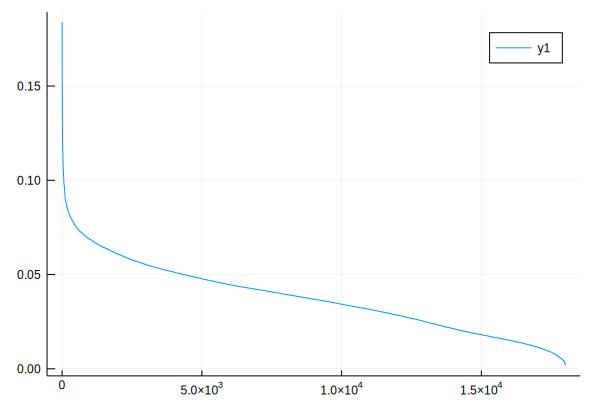

In [3]:
x = collect(1:sol.N_mc)
plot(x[1:end],fdist2[1:end])

In [2]:
db_eps = 0.08
#db_res_hist = dbscan(D_hist,db_eps,20)
db_res_hist = dbscan(D_hist,db_eps,20)

db_res_hist.counts

7-element Array{Int64,1}:
  4972
    31
    91
    95
 11911
    68
    27

In [3]:
cluster_n_noise(db_res_hist)

805

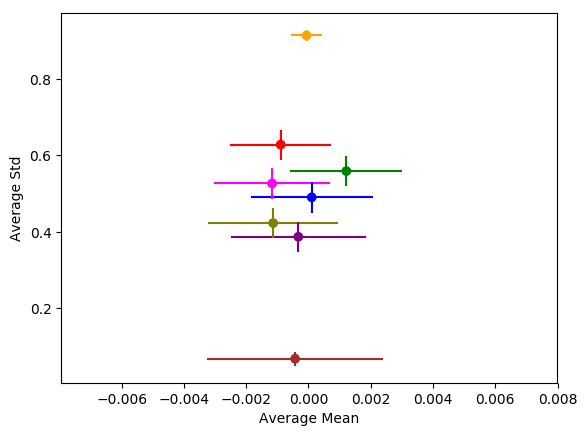

PyObject Text(24.000000000000007, 0.5, 'Average Std')

In [6]:
colororder = ["blue","orange","green","red","purple","brown","magenta","olive","cyan"]
measure_1 = 1
measure_2 = 2

m1m = cluster_measure_mean(sol, db_res_hist, measure_1)
m1sd = cluster_measure_std(sol, db_res_hist, measure_1)
m2m = cluster_measure_mean(sol, db_res_hist, measure_2)
m2sd = cluster_measure_std(sol, db_res_hist, measure_2)
plot_i = 1:8
SC = PyPlot.scatter(m1m[plot_i], m2m[plot_i], c=colororder[1:8])
#PyPlot.legend(SC,["Noise","2","3","4","5","6","7","8","9","10","11"])

PyPlot.errorbar(m1m[plot_i], m2m[plot_i], fmt="o", ms=0, ecolor=colororder, xerr=0.005*m1sd[plot_i], yerr=0.1*m2sd[plot_i])
PyPlot.xlabel("Average Mean")
PyPlot.ylabel("Average Std")

In [3]:
cluster_members = cluster_membership(prob, db_res_hist, [0.05,0.01], [0.01,0.0025]);


we join all mixed / inhomogenous clusters

In [4]:
joined_cluster_member_data = zeros(size(cluster_members.data)[1], size(cluster_members.data)[2], 3)

joined_cluster_member_data[:,:,1] = cluster_members.data[:,:,2]
joined_cluster_member_data[:,:,2] = cluster_members.data[:,:,6]
joined_cluster_member_data[:,:,3] = cluster_members.data[:,:,1] .+ cluster_members.data[:,:,3] .+ cluster_members.data[:,:,4] .+ cluster_members.data[:,:,5] .+ cluster_members.data[:,:,7] .+ cluster_members.data[:,:,8]

joined_cluster_members = ClusterMembershipResult(cluster_members.par, joined_cluster_member_data, true);

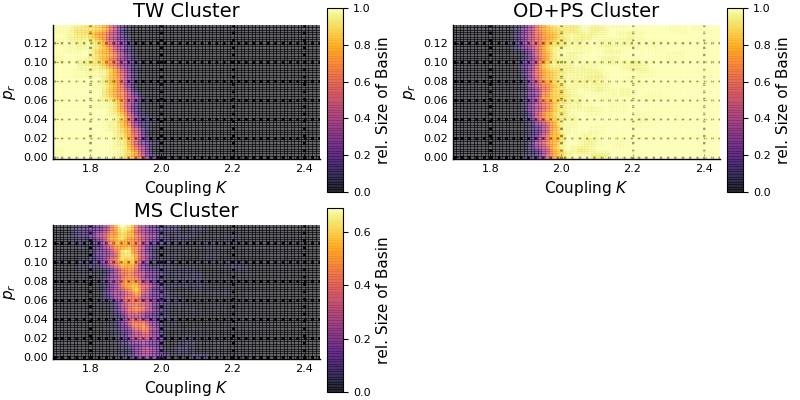

In [5]:
using LaTeXStrings
Plots.pyplot()
clabels = ["TW","OD+PS","MS"]
p1 = Plots.plot(joined_cluster_members, plot_index=1, xlabel=L"Coupling $K$", ylabel=L"$p_r$", title=string(clabels[1], " Cluster"), colorbar_title="rel. Size of Basin")
p2 = Plots.plot(joined_cluster_members, plot_index=2, xlabel=L"Coupling $K$", ylabel=L"$p_r$", title=string(clabels[2], " Cluster"), colorbar_title="rel. Size of Basin")
p3 = Plots.plot(joined_cluster_members, plot_index=3, xlabel=L"Coupling $K$", ylabel=L"$p_r$", title=string(clabels[3], " Cluster"), colorbar_title="rel. Size of Basin")

Plots.plot([p1, p2, p3]..., size=(800,400))

In [6]:
Plots.savefig("sl-2d-pr-cm.pdf")

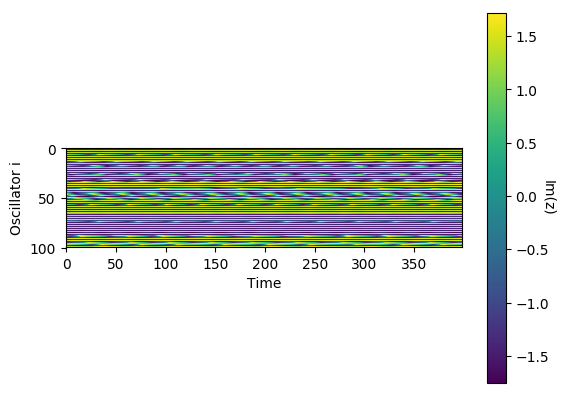

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[10]:6
└ @ Core In[10]:6
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[10]:6
└ @ Core In[10]:6


PyObject Text(554.6355555555557, 0.5, 'Im(z)')

In [10]:
traj1 = get_trajectory(prob, sol, db_res_hist, 1)
IM = PyPlot.imshow(Matrix(imag.(traj1)))
PyPlot.ylabel("Oscillator i")
PyPlot.xlabel("Time")
cb = PyPlot.colorbar(IM)
cb[:ax][:set_ylabel]("Im(z)", rotation=270)

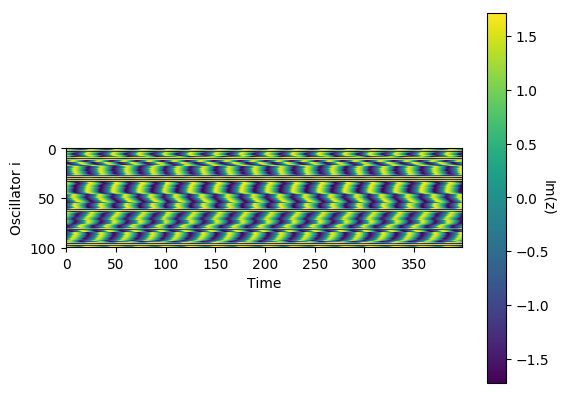

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[11]:6
└ @ Core In[11]:6
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[11]:6
└ @ Core In[11]:6


PyObject Text(554.6355555555557, 0.5, 'Im(z)')

In [11]:
traj2 = get_trajectory(prob, sol, db_res_hist, 2)
IM = PyPlot.imshow(Matrix(imag.(traj2)))
PyPlot.ylabel("Oscillator i")
PyPlot.xlabel("Time")
cb = PyPlot.colorbar(IM)
cb[:ax][:set_ylabel]("Im(z)", rotation=270)

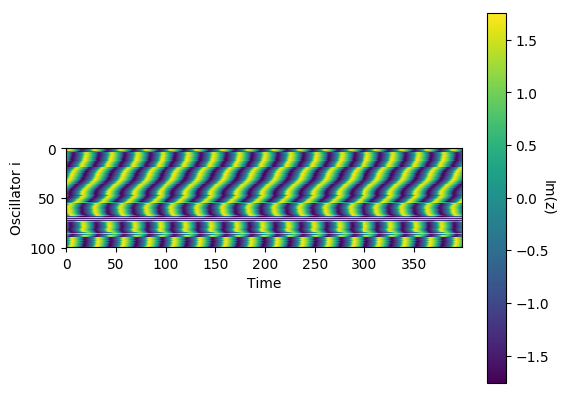

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[12]:6
└ @ Core In[12]:6
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[12]:6
└ @ Core In[12]:6


PyObject Text(554.6355555555557, 0.5, 'Im(z)')

In [12]:
traj3 = get_trajectory(prob, sol, db_res_hist, 3)
IM = PyPlot.imshow(Matrix(imag.(traj3)))
PyPlot.ylabel("Oscillator i")
PyPlot.xlabel("Time")
cb = PyPlot.colorbar(IM)
cb[:ax][:set_ylabel]("Im(z)", rotation=270)

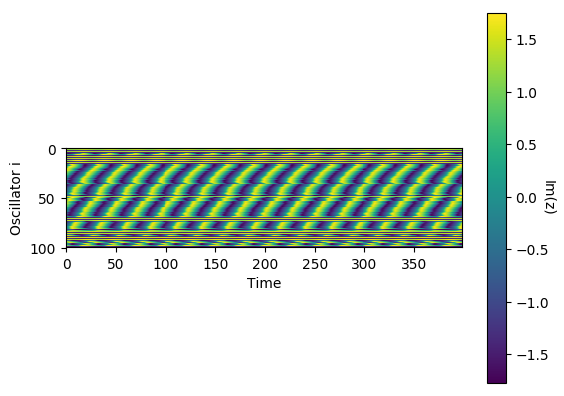

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[13]:6
└ @ Core In[13]:6
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[13]:6
└ @ Core In[13]:6


PyObject Text(554.6355555555557, 0.5, 'Im(z)')

In [13]:
traj4 = get_trajectory(prob, sol, db_res_hist, 4)
IM = PyPlot.imshow(Matrix(imag.(traj4)))
PyPlot.ylabel("Oscillator i")
PyPlot.xlabel("Time")
cb = PyPlot.colorbar(IM)
cb[:ax][:set_ylabel]("Im(z)", rotation=270)

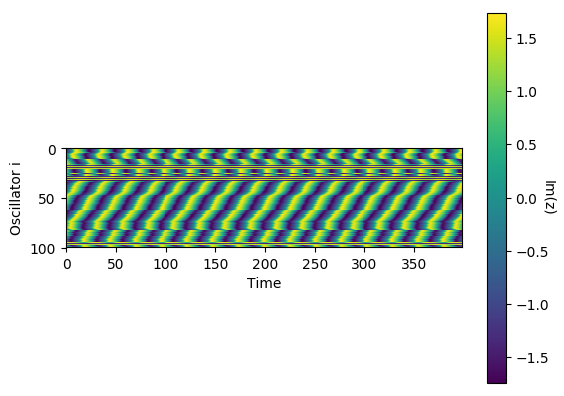

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[14]:6
└ @ Core In[14]:6
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[14]:6
└ @ Core In[14]:6


PyObject Text(554.6355555555557, 0.5, 'Im(z)')

In [14]:
traj5 = get_trajectory(prob, sol, db_res_hist, 5)
IM = PyPlot.imshow(Matrix(imag.(traj5)))
PyPlot.ylabel("Oscillator i")
PyPlot.xlabel("Time")
cb = PyPlot.colorbar(IM)
cb[:ax][:set_ylabel]("Im(z)", rotation=270)

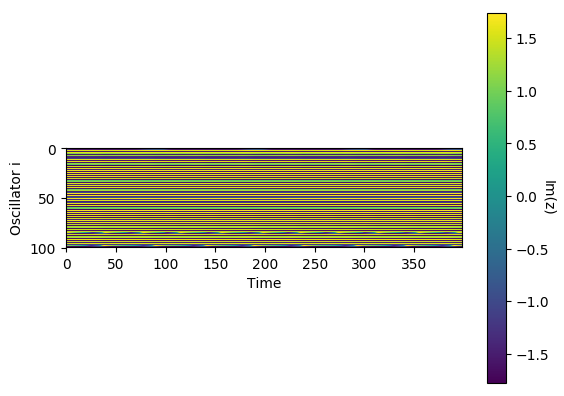

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[15]:6
└ @ Core In[15]:6
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[15]:6
└ @ Core In[15]:6


PyObject Text(554.6355555555557, 0.5, 'Im(z)')

In [15]:
traj6 = get_trajectory(prob, sol, db_res_hist, 6)
IM = PyPlot.imshow(Matrix(imag.(traj6)))
PyPlot.ylabel("Oscillator i")
PyPlot.xlabel("Time")
cb = PyPlot.colorbar(IM)
cb[:ax][:set_ylabel]("Im(z)", rotation=270)

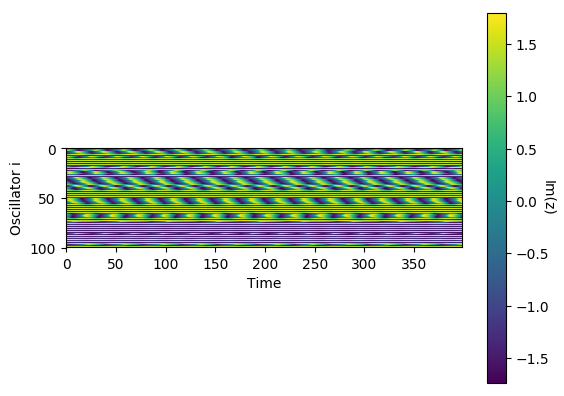

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[16]:6
└ @ Core In[16]:6
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[16]:6
└ @ Core In[16]:6


PyObject Text(554.6355555555557, 0.5, 'Im(z)')

In [16]:
traj7 = get_trajectory(prob, sol, db_res_hist, 7)
IM = PyPlot.imshow(Matrix(imag.(traj7)))
PyPlot.ylabel("Oscillator i")
PyPlot.xlabel("Time")
cb = PyPlot.colorbar(IM)
cb[:ax][:set_ylabel]("Im(z)", rotation=270)

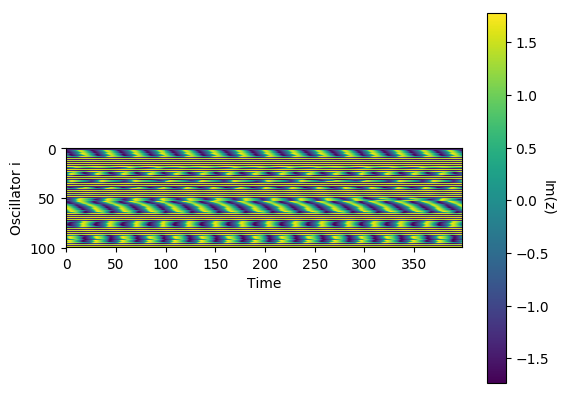

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[17]:6
└ @ Core In[17]:6
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[17]:6
└ @ Core In[17]:6


PyObject Text(554.6355555555557, 0.5, 'Im(z)')

In [17]:
traj8 = get_trajectory(prob, sol, db_res_hist, 8)
IM = PyPlot.imshow(Matrix(imag.(traj8)))
PyPlot.ylabel("Oscillator i")
PyPlot.xlabel("Time")
cb = PyPlot.colorbar(IM)
cb[:ax][:set_ylabel]("Im(z)", rotation=270)